In [6]:
from os.path import isdir, join
import pickle
import numpy as np
import matplotlib.pyplot as plt
# import rosbag
import glob
from sklearn.model_selection import train_test_split, KFold
import os
import pdb
import math
import torch
from datetime import datetime
from torch import nn
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
from os.path import join
from os import makedirs
import time
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [7]:
dataset_filepath = 'short_prediction_multi_intention_data_fast.pt'#'short_prediction_data.pt'
dataset = torch.load(dataset_filepath)

xobs_train, xpred_train, yintention_train, xobs_test, xpred_test, yintention_test = \
dataset["xobs_train"], dataset["xpred_train"], dataset["yintention_train"], dataset["xobs_test"], \
dataset["xpred_test"], dataset["yintention_test"]
obs_seq_len, pred_seq_len = dataset["obs_seq_len"], dataset["pred_seq_len"]

In [8]:
# x_train = torch.cat([xobs_train, xpred_train], dim=1) # (798, 10, 2)
# x_test = torch.cat([xobs_test, xpred_test], dim=1) # (178, 10, 2)
# x_train = x_train[:,1:] - x_train[:,:-1] # (N, 9, 2)
# x_test = x_test[:,1:] - x_test[:,:-1] # (N, 9, 2)
# x_train = torch.cat([torch.zeros(x_train.shape[0], 1, 2), x_train], dim=1) # (N, 10, 2)
# x_test = torch.cat([torch.zeros(x_test.shape[0], 1, 2), x_test], dim=1) # (N, 10, 2)
# xobs_train, xpred_train = x_train[:,:obs_seq_len], x_train[:,obs_seq_len:]
# xobs_test, xpred_test = x_test[:,:obs_seq_len], x_test[:,obs_seq_len:]

In [9]:
class Arguments:
    def __init__(
        self,
        batch_size=32,
        obs_seq_len=4,
        pred_seq_len=6,
        embedding_size=32,
        hidden_size=32,
        num_layers=1,
        dropout=0.,
        lr=1e-3,
        num_epochs=100,
        clip_grad=10.,
        device="cuda:0",
        checkpoint_dir="checkpoints",
        ):
        self.batch_size = batch_size
        self.obs_seq_len = obs_seq_len
        self.pred_seq_len = pred_seq_len
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lr = lr
        self.num_epochs = num_epochs
        self.clip_grad = clip_grad
        self.device = device
        self.checkpoint_dir=checkpoint_dir

args = Arguments(
    obs_seq_len=obs_seq_len,
    pred_seq_len=pred_seq_len,
    lr=5e-3,
    device=device,
)

In [10]:
class TrajectoriesDataset(Dataset):
    def __init__(
        self,
        xobs,
        xpred,
        yintention,
        obs_seq_len=4,
        pred_seq_len=6,
        ):
        super(TrajectoriesDataset, self).__init__()
        assert xobs.shape[0]==xpred.shape[0]==yintention.shape[0]
        assert xobs.shape[1]==obs_seq_len and xpred.shape[1]==pred_seq_len
        self.obs_seq_len = obs_seq_len
        self.pred_seq_len = pred_seq_len
        self.seq_len = self.obs_seq_len + self.pred_seq_len
        self.xobs = xobs
        self.xpred = xpred
        self.yintention = yintention
        self.num_seq = self.xobs.shape[0]

    def __len__(self):
        return self.num_seq


    def __getitem__(self, index):
        out = [
            self.xobs[index],
            self.xpred[index],
            self.yintention[index],
        ]
        return out

In [11]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)
for train_index, validation_index in kf.split(xobs_train):
    xobs_train_k, xobs_val_k = xobs_train[train_index], xobs_train[validation_index]
    xpred_train_k, xpred_val_k = xpred_train[train_index], xpred_train[validation_index] 
    yintention_train_k, yintention_val_k = yintention_train[train_index], yintention_train[validation_index]
    dataset_train = TrajectoriesDataset(
        xobs_train_k,
        xpred_train_k,
        yintention_train_k,
        obs_seq_len=obs_seq_len,
        pred_seq_len=pred_seq_len,
    )
    dataset_val = TrajectoriesDataset(
        xobs_val_k,
        xpred_val_k,
        yintention_val_k,
        obs_seq_len=obs_seq_len,
        pred_seq_len=pred_seq_len,
    )
    loader_train = DataLoader(
        dataset_train,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=4,  
    )
    loader_val = DataLoader(
        dataset_val,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=4,  
    )
    break

    
dataset_test = TrajectoriesDataset(
    xobs_test,
    xpred_test,
    yintention_test,
    obs_seq_len=obs_seq_len,
    pred_seq_len=pred_seq_len,
)

loader_test = DataLoader(
    dataset_test,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=4,  
)

In [12]:
class IntentionLstm(nn.Module):
    def __init__(
        self,
        embedding_size=32,
        hidden_size=32,
        num_layers=1,
        dropout=0.,
        bidirectional=False,
        obs_seq_len=4,
        pred_seq_len=6,
        motion_dim=3,
    ):
        super(IntentionLstm, self).__init__()
        self.lstm = nn.LSTM(
            input_size=2*embedding_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional,
            )
        self.spatial_embedding = nn.Linear(motion_dim, embedding_size)
        self.intention_embedding = nn.Linear(1, embedding_size)
        if bidirectional:
            self.directions = 2
        else:
            self.directions = 1
        self.hidden_to_pos = nn.Linear(self.directions*num_layers*hidden_size, motion_dim)
        self.embedding_size = embedding_size
        self.obs_seq_len = obs_seq_len
        self.pred_seq_len = pred_seq_len
    
    def forward(self, b_xobs, b_yintention, device="cuda:0"):
        
        """
        Forward function.
        inputs:
            - b_xobs: batch of observation. (batch, obs_seq_len, 2)
            - b_yintention: batch of intention. (batch, 1)
        outputs:
            - b_xpred: (batch, pred_seq_len, 2)
            
        """
        batch_size, _, _ = b_xobs.shape
        b_xobs_offset = (b_xobs[:,1:] - b_xobs[:,:-1]).float() # (N, obs_seq_len-1,2)
        b_xobs_offset_embedding = self.spatial_embedding(b_xobs_offset) # (batch, obs_seq_len, embedding_size)
        b_yintention_embedding = self.intention_embedding(b_yintention.unsqueeze(-1)) # (batch, 1, embedding_size)
        b_obs_embedding = torch.cat((b_xobs_offset_embedding, \
                                   b_yintention_embedding*torch.ones(batch_size, self.obs_seq_len-1, self.embedding_size).to(device)), \
                                   dim=2) # (batch, obs_seq_len-1, 2*embedding_size)
        _, (ht, ct) = self.lstm(b_obs_embedding) # (D∗num_layers, batch, hidden_size)
        b_xpred_tt = b_xobs[:,-1:] # (batch, 1, 2)
        b_xpred = []
        b_xpred_tt_offset = self.hidden_to_pos(ht.permute(1,0,2).reshape(batch_size,1,-1)) # (batch, 1, 2)
        b_xpred_tt = b_xpred_tt + b_xpred_tt_offset
        b_xpred.append(b_xpred_tt)
        for tt in range(1, self.pred_seq_len):
            b_pred_tt_offset_embedding = torch.cat((self.spatial_embedding(b_xpred_tt_offset), b_yintention_embedding), dim=2)
            _, (ht, ct) = self.lstm(b_pred_tt_offset_embedding, (ht, ct))
            b_xpred_tt_offset = self.hidden_to_pos(ht.permute(1,0,2).reshape(batch_size,1,-1)) # (batch, 1, 2)
            b_xpred_tt = b_xpred_tt + b_xpred_tt_offset
            b_xpred.append(b_xpred_tt)
        b_xpred = torch.cat(b_xpred, dim=1)
        return b_xpred

In [13]:
def train(args, loader_train, loader_val):
    model = IntentionLstm(
        embedding_size=args.embedding_size,
        hidden_size=args.hidden_size,
        num_layers=args.num_layers,
        dropout=args.dropout,
        bidirectional=False,
        obs_seq_len=args.obs_seq_len,
        pred_seq_len=args.pred_seq_len,
    ).to(args.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    now = datetime.now()
    curr_checkpoint_dir = join(args.checkpoint_dir, now.strftime("%y%m%d_%H%M%S"))
    if not isdir(curr_checkpoint_dir):
        makedirs(curr_checkpoint_dir)
    with open(join(curr_checkpoint_dir, 'args.pickle'), 'wb') as f:
        pickle.dump(args, f)
    print('EPOCHS: ', args.num_epochs)
    train_loss_task, train_aoe_task, train_foe_task = [], [], []
    val_loss_task, val_aoe_task, val_foe_task = [], [], []
    
    for epoch in range(1, args.num_epochs+1):
        epoch_start_time = time.time()
        model.train()
        train_loss_epoch, train_aoe_epoch, train_foe_epoch = [], [], []
        for batch_idx, batch in enumerate(loader_train):
            batch = [b.to(args.device) for b in batch]
            b_xobs, b_xpred_gt, b_yintention = batch
            optimizer.zero_grad()
            b_xpred = model(b_xobs, b_yintention, device=args.device) # (batch, pred_seq_len, 2)
            loss = ((b_xpred-b_xpred_gt)**2.).mean()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), args.clip_grad)
            optimizer.step()
            offset_error = (((b_xpred-b_xpred_gt)**2.).sum(2))**0.5 # (batch, pred_seq_len)
            aoe, foe = offset_error.mean(-1).mean(), offset_error[-1].mean()
            train_loss_epoch.append(loss.detach().to('cpu').item())
            train_aoe_epoch.append(aoe.detach().to('cpu').item())
            train_foe_epoch.append(foe.detach().to('cpu').item())
        train_loss_epoch = sum(train_loss_epoch)/len(train_loss_epoch)
        train_aoe_epoch = sum(train_aoe_epoch)/len(train_aoe_epoch)
        train_foe_epoch = sum(train_foe_epoch)/len(train_foe_epoch)
        val_loss_epoch, val_aoe_epoch, val_foe_epoch = inference(args, loader_val, model)
        if epoch % 10 == 0:
#             print('Epoch: {0} | train loss: {1:.2f} | val loss: {2:.2f} | train aoe: {3:.2f} | val aoe: {4:.2f} | train foe: {5:.2f} | val foe: {6:.2f} | period: {7:.2f} sec'\
#                 .format(epoch, train_loss_epoch, val_loss_epoch,\
#                 train_aoe_epoch, val_aoe_epoch,\
#                 train_foe_epoch, val_foe_epoch,\
#                 time.time()-epoch_start_time)) 
            print('Epoch: {0} | train aoe: {1:.2f} | val aoe: {2:.2f} | train foe: {3:.2f} | val foe: {4:.2f} | period: {5:.2f} sec'\
                .format(epoch, \
                train_aoe_epoch, val_aoe_epoch,\
                train_foe_epoch, val_foe_epoch,\
                time.time()-epoch_start_time)) 
            model_filename = join(curr_checkpoint_dir, 'epoch_'+str(epoch)+'.pt')
            torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss_epoch,
                    'val_loss': val_loss_epoch,
                    'train_aoe': train_aoe_epoch,
                    'val_aoe': val_aoe_epoch, 
                    'train_foe': train_foe_epoch,
                    'val_foe': val_foe_epoch,   
                    }, model_filename)
            # print('epoch_'+str(epoch)+'.pt is saved.')
        train_loss_task.append(train_loss_epoch)
        train_aoe_task.append(train_aoe_epoch)
        train_foe_task.append(train_foe_epoch)
        val_loss_task.append(val_loss_epoch)
        val_aoe_task.append(val_aoe_epoch)
        val_foe_task.append(val_foe_epoch)
    hist = {}
    hist['train_loss'], hist['val_loss'] = train_loss_task, val_loss_task
    hist['train_aoe'], hist['val_aoe'] = train_aoe_task, val_aoe_task
    hist['train_foe'], hist['val_foe'] = train_foe_task, val_foe_task
    with open(join(curr_checkpoint_dir, 'train_hist.pickle'), 'wb') as f:
        pickle.dump(hist, f)
        print(join(curr_checkpoint_dir, 'train_hist.pickle')+' is saved.')
    return


def inference(args, loader, model, reverse_intention=False):
    with torch.no_grad():
        model.eval()
        loss_epoch, aoe_epoch, foe_epoch = [], [], []
        for batch_idx, batch in enumerate(loader):
            batch = [b.to(args.device) for b in batch]
            b_xobs, b_xpred_gt, b_yintention = batch
            if reverse_intention:
                b_yintention = 1.-b_yintention
            b_xpred = model(b_xobs, b_yintention, device=args.device) # (batch, pred_seq_len, 2)
            loss = ((b_xpred-b_xpred_gt)**2.).mean()
            offset_error = (((b_xpred-b_xpred_gt)**2.).sum(2))**0.5 # (batch, pred_seq_len)
            aoe, foe = offset_error.mean(-1).mean(), offset_error[-1].mean()
            loss_epoch.append(loss.detach().to('cpu').item())
            aoe_epoch.append(aoe.detach().to('cpu').item())
            foe_epoch.append(foe.detach().to('cpu').item())
        loss_epoch = sum(loss_epoch)/len(loss_epoch)
        aoe_epoch = sum(aoe_epoch)/len(aoe_epoch)
        foe_epoch = sum(foe_epoch)/len(foe_epoch)
    return loss_epoch, aoe_epoch, foe_epoch

In [14]:
train(args, loader_train, loader_val)

EPOCHS:  300
Epoch: 10 | train aoe: 24.14 | val aoe: 20.95 | train foe: 20.65 | val foe: 15.16 | period: 0.42 sec
Epoch: 20 | train aoe: 24.53 | val aoe: 20.50 | train foe: 27.44 | val foe: 18.25 | period: 0.42 sec
Epoch: 30 | train aoe: 25.49 | val aoe: 25.08 | train foe: 28.27 | val foe: 20.35 | period: 0.43 sec
Epoch: 40 | train aoe: 25.24 | val aoe: 21.41 | train foe: 28.22 | val foe: 19.65 | period: 0.43 sec
Epoch: 50 | train aoe: 25.09 | val aoe: 25.04 | train foe: 24.12 | val foe: 23.67 | period: 0.42 sec
Epoch: 60 | train aoe: 24.73 | val aoe: 26.07 | train foe: 23.77 | val foe: 24.78 | period: 0.42 sec
Epoch: 70 | train aoe: 23.12 | val aoe: 21.20 | train foe: 31.40 | val foe: 16.84 | period: 0.42 sec
Epoch: 80 | train aoe: 24.84 | val aoe: 18.77 | train foe: 24.72 | val foe: 13.77 | period: 0.43 sec
Epoch: 90 | train aoe: 23.02 | val aoe: 23.90 | train foe: 23.34 | val foe: 24.32 | period: 0.42 sec
Epoch: 100 | train aoe: 20.30 | val aoe: 21.51 | train foe: 17.10 | val foe: 1

In [20]:

def test(loader_test, name_checkpoint, visualize=True):
    curr_checkpoint_dir = join(args.checkpoint_dir, name_checkpoint)
    if not isdir(curr_checkpoint_dir):
        raise RuntimeError("Checkpoint "+name_checkpoint+" does not exist.")
    with open(join(curr_checkpoint_dir, 'args.pickle'), 'rb') as f:
        args_eval = pickle.load(f)
    model = IntentionLstm(
        embedding_size=args.embedding_size,
        hidden_size=args.hidden_size,
        num_layers=args.num_layers,
        dropout=args.dropout,
        bidirectional=False,
        obs_seq_len=args.obs_seq_len,
        pred_seq_len=args.pred_seq_len,
    ).to(args.device)
    model_checkpoint_filename = join(curr_checkpoint_dir, "epoch_"+str(args.num_epochs)+".pt")
    model_checkpoint = torch.load(model_checkpoint_filename, map_location=device)
    model.load_state_dict(model_checkpoint['model_state_dict'])
    print('Loaded configuration: ', model_checkpoint_filename)
    start_time = time.time()
    test_loss_epoch, test_aoe_epoch, test_foe_epoch = inference(args, loader_test, model)
    end_time = time.time()
    test_loss_epoch_ri, test_aoe_epoch_ri, test_foe_epoch_ri = inference(args, loader_test, model, reverse_intention=True)
    print('Epoch: {0} | test aoe: {1:.2f} | test foe: {2:.2f} | period: {3:.2f} sec | not reversed'\
        .format(args.num_epochs, \
        test_aoe_epoch,\
        test_foe_epoch,\
        end_time-start_time))
    print('Epoch: {0} | test aoe: {1:.2f} | test foe: {2:.2f} | period: {3:.2f} sec | reversed'\
        .format(args.num_epochs, \
        test_aoe_epoch_ri,\
        test_foe_epoch_ri,\
        end_time-start_time))
    if visualize:
        %matplotlib notebook
        with torch.no_grad():
            model.eval()
            for batch_idx, batch in enumerate(loader_test):
                batch = [b.to(args.device) for b in batch]
                b_xobs, b_xpred_gt, b_yintention = batch
                b_xpred = model(b_xobs, b_yintention, device=args.device) # (batch, pred_seq_len, 2)
                b_xpred_reverse_intention = model(b_xobs, 1.-b_yintention, device=args.device) # (batch, pred_seq_len, 2)
                b_x_gt = torch.cat([b_xobs, b_xpred_gt],dim=1).to("cpu")
                b_x_model = torch.cat([b_xobs, b_xpred],dim=1).to("cpu")
                b_x_model_2 = torch.cat([b_xobs, b_xpred_reverse_intention],dim=1).to("cpu")
                b_xobs = b_xobs.to("cpu")
                b_xpred_gt = b_xpred_gt.to("cpu")
                b_xpred = b_xpred.to("cpu")
#                 offset_error = ((b_xpred_gt-b_xpred)**2.).sum(2)**0.5 # (N, Tpred)
#                 print("aoe: ", offset_error.mean())
#                 print("foe: ", offset_error[:,-1].mean())
#                 for traj_idx in range(len(b_xobs)):
#                     plt.figure()
#                     plt.plot(b_x_gt[traj_idx,:,0], b_x_gt[traj_idx,:,1], 'o-', c='C0') # blue
#                     plt.plot(b_x_model[traj_idx,:,0], b_x_model[traj_idx,:,1], 'o-', c='C1', markersize=10.) # orange
#                     plt.plot(b_x_model_2[traj_idx,:,0], b_x_model_2[traj_idx,:,1], 'o-', c='C2') # green
# #                     print(b_x_model[traj_idx]-)
#                     print(b_yintention[traj_idx])
                for traj_idx in range(len(b_xobs)):
        
                    offset_error = ((b_xpred_gt[traj_idx:traj_idx+1,:]-b_xpred[traj_idx:traj_idx+1,:])**2.).sum(2)**0.5 # (1, Tpred)
                    plt.figure()
                    ax = plt.axes(projection='3d')
                    ax.scatter3D(b_x_gt[traj_idx,:,0], b_x_gt[traj_idx,:,1],b_x_gt[traj_idx,:,2], 'o-', c='C0') # blue for ground truth prediction
                    ax.plot3D(b_x_gt[traj_idx,:,0], b_x_gt[traj_idx,:,1],b_x_gt[traj_idx,:,2], 'o-', c='C0') # blue for ground truth prediction
                    
                    ax.scatter3D(b_x_model[traj_idx,:,0], b_x_model[traj_idx,:,1],b_x_model[traj_idx,:,2], 'o-', c='r') # red for true intention
                    ax.plot3D(b_x_model[traj_idx,:,0], b_x_model[traj_idx,:,1],b_x_model[traj_idx,:,2], 'o-', c='r') # red for true intention
                    
                    ax.scatter3D(b_x_model_2[traj_idx,:,0], b_x_model_2[traj_idx,:,1],b_x_model_2[traj_idx,:,2], 'o-', c='g') # green for wrong intention
                    ax.plot3D(b_x_model_2[traj_idx,:,0], b_x_model_2[traj_idx,:,1],b_x_model_2[traj_idx,:,2], 'o-', c='g') # green for wrong intention
                    
                    ax.scatter3D(b_xobs[traj_idx,:,0], b_xobs[traj_idx,:,1],b_xobs[traj_idx,:,2], 'o-', c='k') # black
                    ax.plot3D(b_xobs[traj_idx,:,0], b_xobs[traj_idx,:,1],b_xobs[traj_idx,:,2], 'o-', c='k') # black  
                    plt.show()
                    print("aoe: ", offset_error.mean())
                    print("foe: ", offset_error[0,-1])
                break

ModuleNotFoundError: No module named 'ipympl'

In [ ]:
for batch_idx, batch in enumerate(loader_test):
    batch = [b.to(args.device) for b in batch]
    b_xobs, b_xpred_gt, b_yintention = batch
    print(b_xobs.shape)
    print(b_xpred_gt.shape)
    break

Loaded configuration:  checkpoints_multi_intention/211103_100638/epoch_300.pt
Epoch: 300 | test aoe: 0.01 | test foe: 0.02 | period: 0.17 sec | not reversed
Epoch: 300 | test aoe: 0.01 | test foe: 0.02 | period: 0.17 sec | reversed


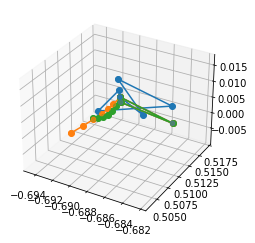

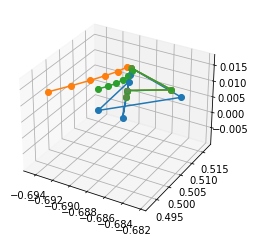

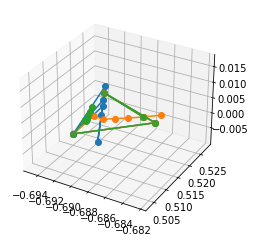

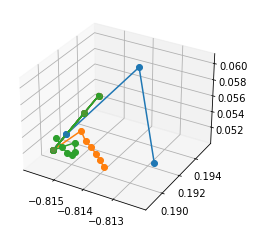

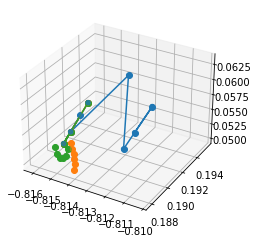

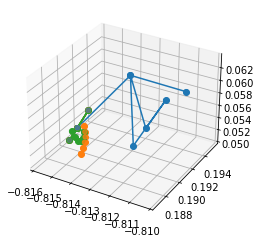

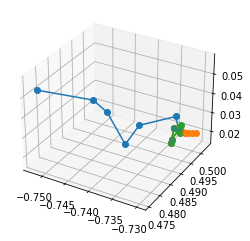

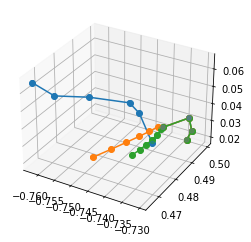

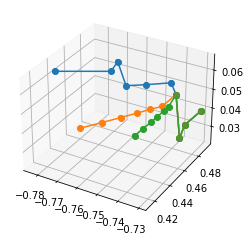

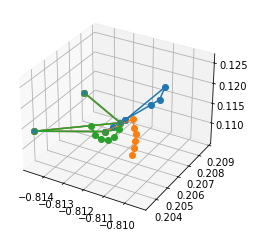

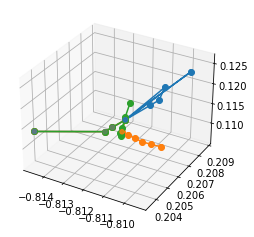

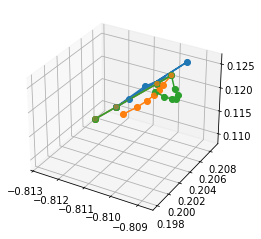

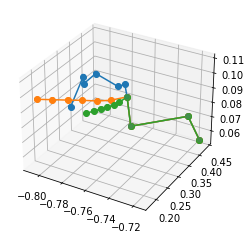

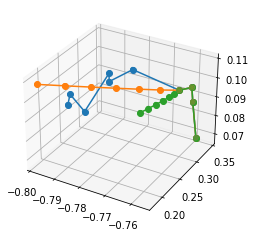

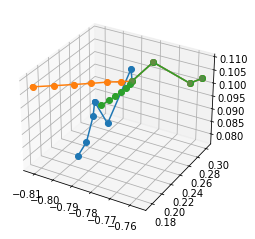

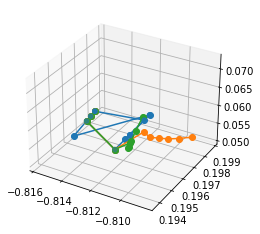

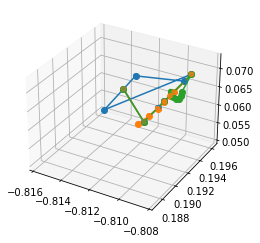

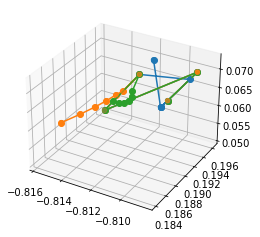

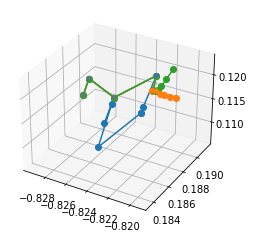

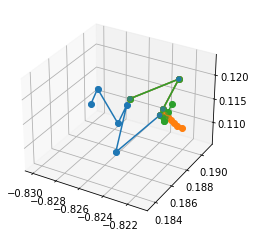

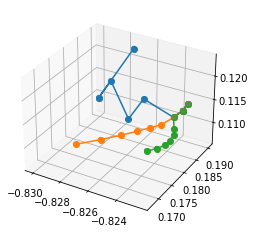

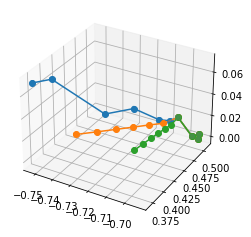

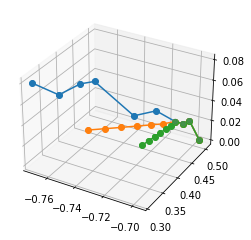

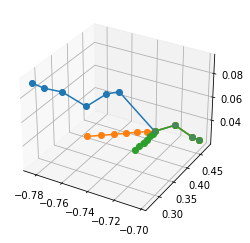

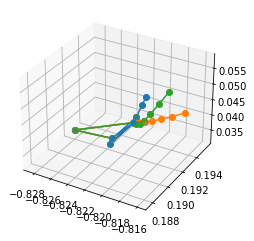

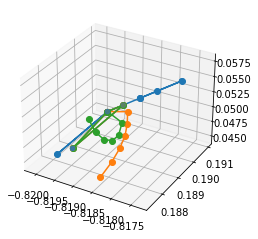

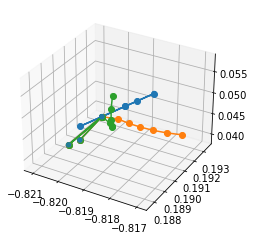

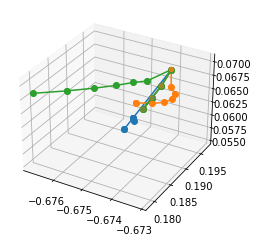

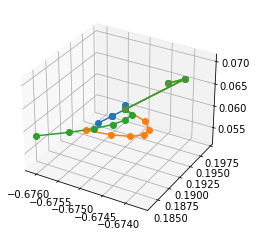

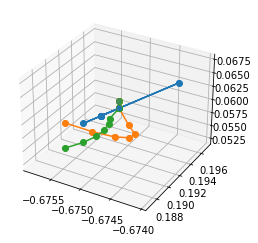

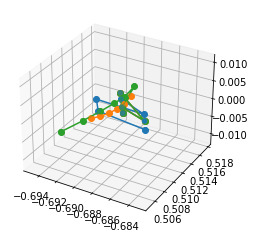

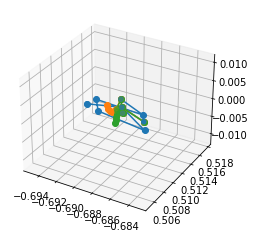

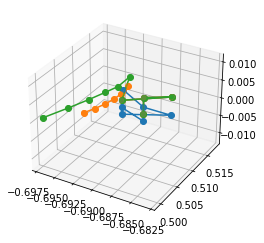

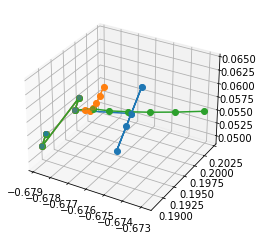

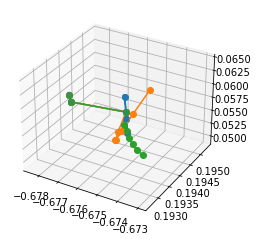

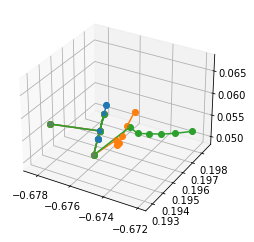

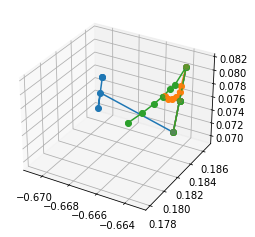

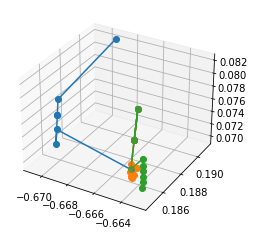

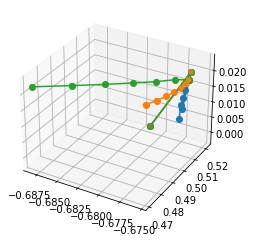

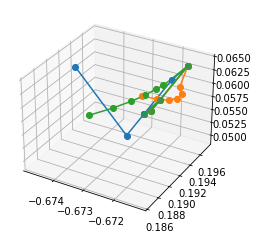

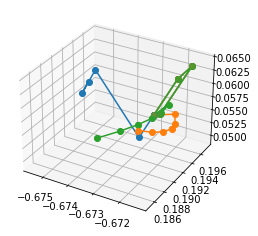

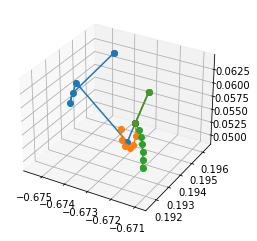

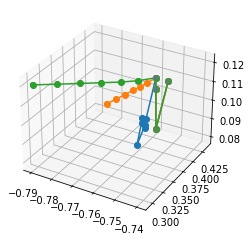

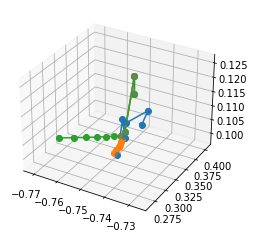

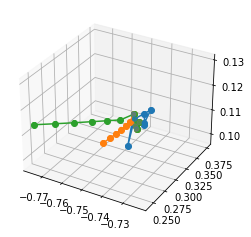

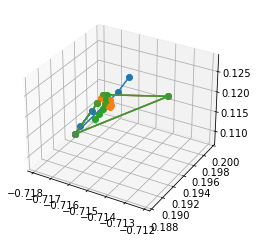

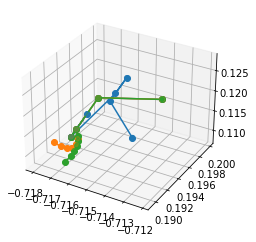

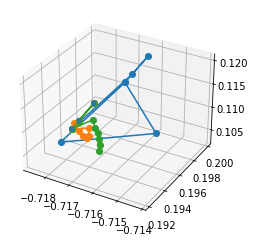

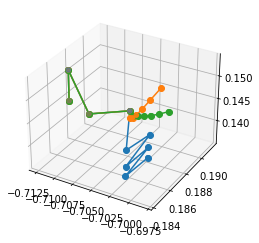

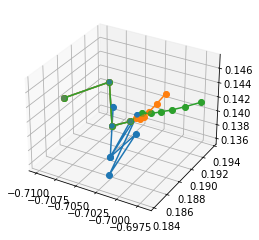

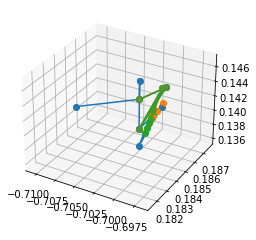

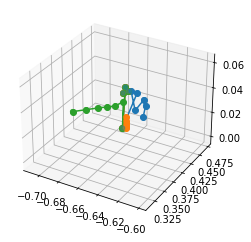

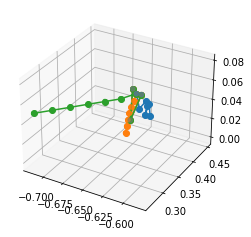

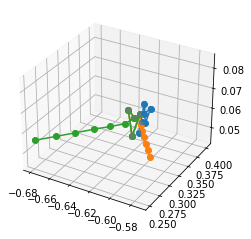

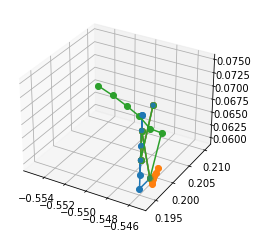

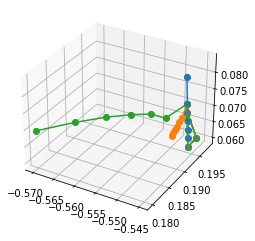

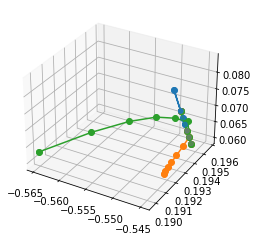

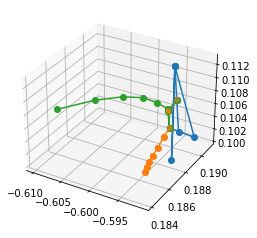

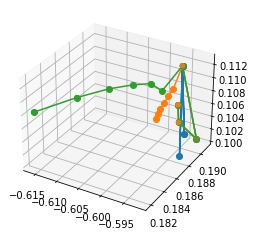

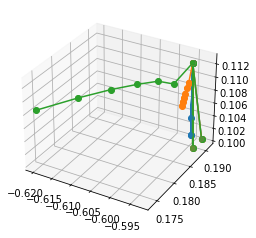

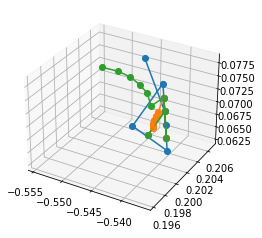

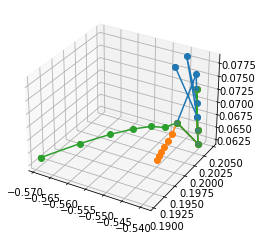

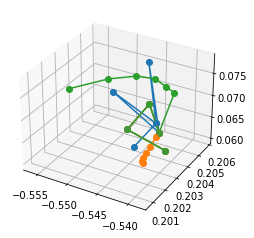

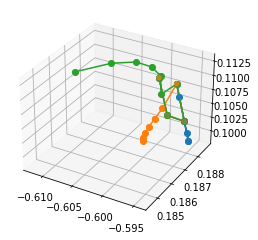

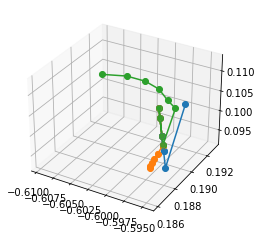

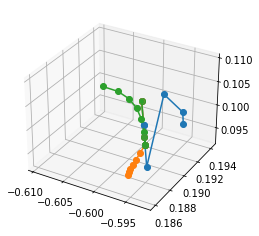

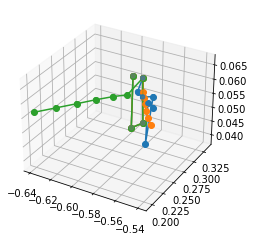

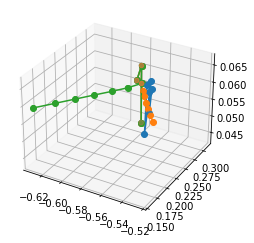

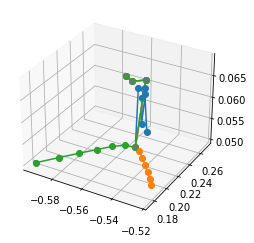

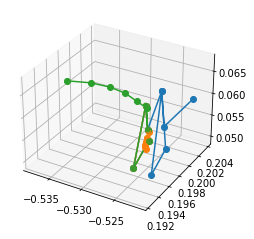

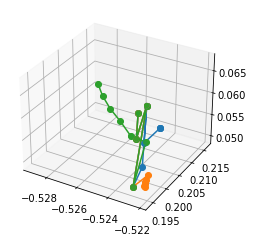

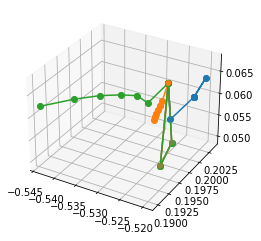

In [ ]:
name_checkpoint = "211103_100638"
test(loader_test, name_checkpoint)